## Looking for the Higgs boson in 4 lepton final state, data edition

In [13]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

file_names = {"ggH":"../data/ATLAS/higgs/mc_345060.ggH125_ZZ4lep.4lep.root",
              "Zjets":"../data/ATLAS/higgs/mc_ZeeZmumu.4lep.root", 
              "diboson":"../data/ATLAS/higgs/mc_363490.llll.VV.4lep.root", 
              "ttbar":"../data/ATLAS/higgs/mc_410000.ttbar_lep.4lep.root",
              "data":"../data/ATLAS/data.4lep.root"}
files = {}
for fname in file_names.keys():
    files[fname] = uproot.open(file_names[fname])

In [77]:
tree = b'mini;1'
branches = [ b'lep_pt', b'lep_eta', 
             b'lep_phi', b'lep_E',
             b'lep_isTightID',b'lep_etcone20',
             b'lep_type',b'lep_charge',
             b'scaleFactor_MUON',b'scaleFactor_ELE',
             b'scaleFactor_PILEUP',b'scaleFactor_LepTRIGGER',
             b'mcWeight']
kins = {}
for fname in file_names.keys():
    kins[fname] = {}
    for branch in branches:
        kins[fname][branch] = files[fname][tree].array(branch)

In [8]:
def make_fig(xTitle="xTitle",yTitle="yTitle"):
    fig = plt.figure(figsize=(15,10))

    ax = plt.gca()
    ax.set_prop_cycle(color=['#002BFF','#A15FFF','#FF0061','#FF8913'])
    ax.set_xlabel(xTitle,fontsize=26,labelpad=6)
    ax.set_ylabel(yTitle,fontsize=26)
    ax.tick_params(labelsize=18, direction='out', length=8, width=2)
    ax.yaxis.offsetText.set_fontsize(18)
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 15
    ax.tick_params(axis='both', which='major', labelsize=25)
    
    return fig, ax

In [16]:
# convert everything to a more numpy friendly format
vars = {}
for fname in file_names.keys():
    vars[fname] = {}
    vars[fname][b'lep_pt']  = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_pt']]) 
    vars[fname][b'lep_phi'] = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_phi']])
    vars[fname][b'lep_eta'] = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_eta']])
    vars[fname][b'lep_E']   = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_E']])
    vars[fname][b'lep_charge']   = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_charge']])
    vars[fname][b'lep_type']   = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_type']])
    vars[fname][b'lep_isTightID']   = np.array([[x[0],x[1],x[2],x[3]] for x in kins[fname][b'lep_isTightID']])

In [93]:
# Get weights
weights = {}
for fname in file_names.keys():
    sfs = [kins[fname][b'scaleFactor_MUON'],
       kins[fname][b'scaleFactor_ELE'],
       kins[fname][b'scaleFactor_PILEUP'],
       kins[fname][b'scaleFactor_LepTRIGGER'],
       kins[fname][b'mcWeight']]
    weights[fname] = np.prod(np.vstack(sfs), axis=0)

In [84]:
GeVperMeV = 1./1000
for fname in file_names.keys():
    vars[fname][b'lep_px']     = vars[fname][b'lep_pt']*np.cos ( vars[fname][b'lep_phi']) * GeVperMeV
    vars[fname][b'lep_py']     = vars[fname][b'lep_pt']*np.sin ( vars[fname][b'lep_phi']) * GeVperMeV
    vars[fname][b'lep_pz']     = vars[fname][b'lep_pt']*np.sinh( vars[fname][b'lep_eta']) * GeVperMeV
    vars[fname][b'lep_E_GeV']  = vars[fname][b'lep_E'] * GeVperMeV

In [86]:
for fname in file_names.keys():
    vars[fname][b'higgs_px'] = np.array([ np.sum(i) for i in vars[fname][b'lep_px'] ] )
    vars[fname][b'higgs_py'] = np.array([ np.sum(i) for i in vars[fname][b'lep_py'] ] )
    vars[fname][b'higgs_pz'] = np.array([ np.sum(i) for i in vars[fname][b'lep_pz'] ] )
    vars[fname][b'higgs_E']  = np.array([ np.sum(i) for i in vars[fname][b'lep_E_GeV'] ] )

In [24]:
for fname in file_names.keys():
    vars[fname][b'higgs_pt'] = np.sqrt(vars[fname][b'higgs_px']**2+vars[fname][b'higgs_py']**2)
    vars[fname][b'higgs_p'] = np.sqrt(vars[fname][b'higgs_pt']**2+vars[fname][b'higgs_pz']**2)
    vars[fname][b'higgs_m'] = np.sqrt(vars[fname][b'higgs_E']**2 - vars[fname][b'higgs_p']**2)

In [87]:
# let's look at charge and type!
for fname in file_names.keys():
    vars[fname][b'higgs_charge'] = np.array([ np.sum(i) for i in vars[fname][b'lep_charge'] ] )
    vars[fname][b'higgs_type'] = np.array([ np.sum(i) for i in vars[fname][b'lep_type'] ] )
    vars[fname][b'higgs_tight'] = np.array([ np.sum(i) for i in vars[fname][b'lep_isTightID'] ] )


## Apply cuts

In [88]:
good_higgs_indices = {}
# apply a handful of cuts
for fname in file_names.keys():
    good_higgs_indices[fname] = []
    for index in range(len(vars[fname][b'lep_pt'])):
        if np.sum(vars[fname][b'lep_charge'][index]) != 0:
            continue
        elif (np.sum(vars[fname][b'lep_type'][index]) != 44 and 
            np.sum(vars[fname][b'lep_type'][index]) != 48 and 
            np.sum(vars[fname][b'lep_type'][index]) != 52):
            continue
        good_higgs_indices[fname].append(index)
    print("{}: Efficiency of cut: {:.3}".format(fname, len(good_higgs_indices[fname])/len(vars[fname][b'lep_isTightID'])))
    good_higgs_indices[fname] = np.array(good_higgs_indices[fname])

ggH: Efficiency of cut: 0.98
Zjets: Efficiency of cut: 0.316
diboson: Efficiency of cut: 0.945
ttbar: Efficiency of cut: 0.324
data: Efficiency of cut: 0.609


In [94]:
nice_good_evt = {}
for fname in file_names.keys():
    nice_good_evt[fname] = {}
    nice_good_evt[fname][b'higgs_m'] = np.take(vars[fname][b'higgs_m'],good_higgs_indices[fname])
    nice_good_evt[fname]["weights"] = np.take(weights[fname],good_higgs_indices[fname])

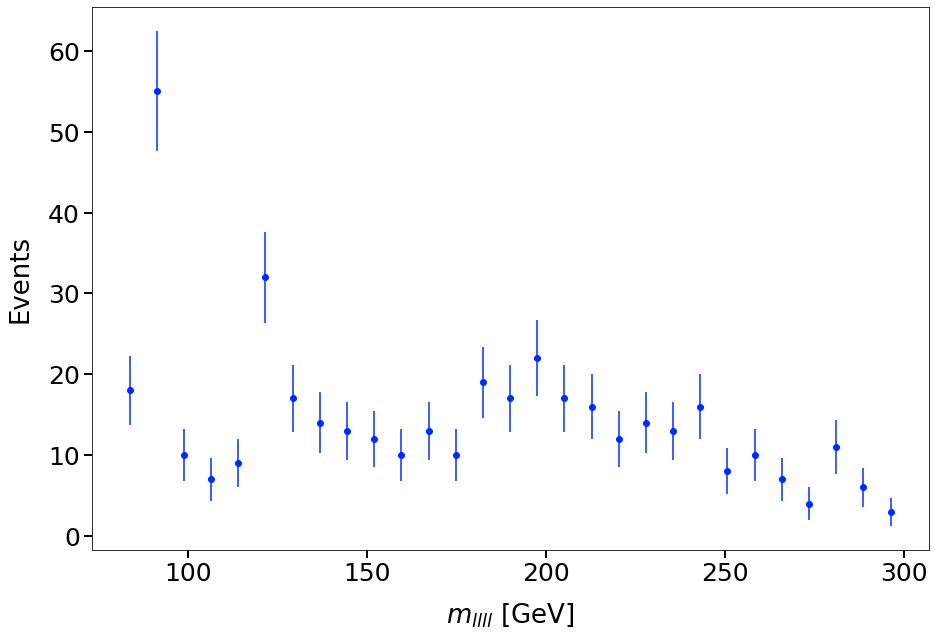

In [71]:
# Plot data as points
n2, bins2, patches2 = ax.hist(nice_good_evt["data"][b'higgs_m'], 
                           np.linspace(80,300,30),linewidth=3,
                           histtype='step',
                           edgecolor="black",linestyle='-',label="Data");
fig, ax = make_fig(xTitle="$m_{llll}$ [GeV]",yTitle="Events")
bins_mean2 = [0.5 * (bins2[i] + bins2[i+1]) for i in range(len(n2))]
err2 = [np.sqrt(pt) for pt in n2]

cutplot = plt.errorbar(bins_mean2, n2,yerr=err2,fmt="o")

/Users/annwang/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


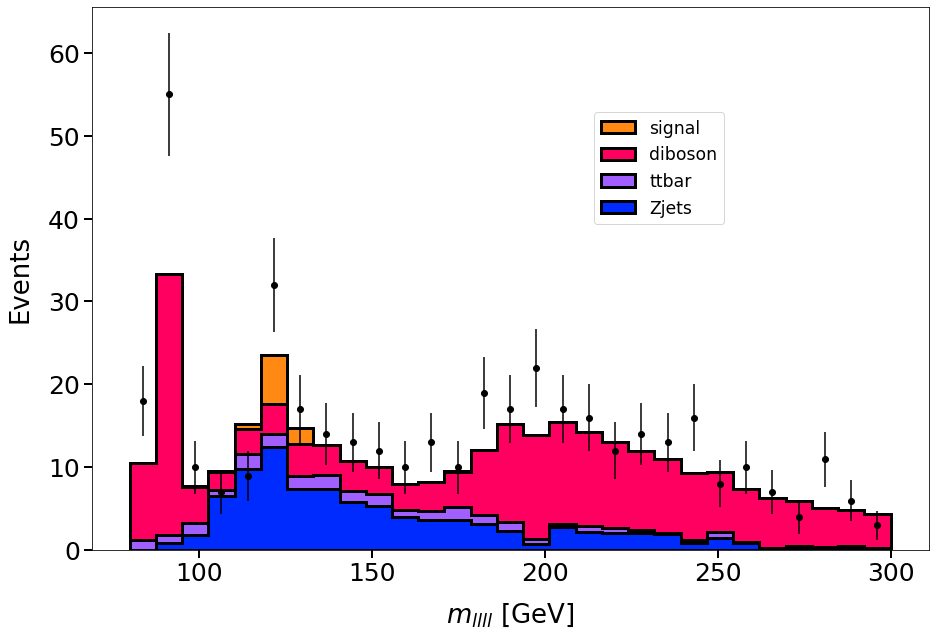

In [99]:
# Normalization for each MC
wg = {"Zjets":0.00013*nice_good_evt["Zjets"]["weights"],
      "ttbar":0.09*nice_good_evt["ttbar"]["weights"],
      "diboson":0.001668*nice_good_evt["diboson"]["weights"],
      "ggH":2.16e-06*nice_good_evt["ggH"]["weights"],
      "data":np.ones(len(nice_good_evt["ggH"][b'higgs_m']))}

# Make histogram and extract bins
fig, ax = make_fig(xTitle="$m_{llll}$ [GeV]",yTitle="Events")
data = [nice_good_evt["Zjets"][b'higgs_m'],
        nice_good_evt["ttbar"][b'higgs_m'],
        nice_good_evt["diboson"][b'higgs_m'],
        nice_good_evt["ggH"][b'higgs_m']]
wgts = [wg["Zjets"],wg["ttbar"],wg["diboson"],wg["ggH"]]
n, bins, patches = ax.hist(data, 
                           np.linspace(80,300,30),linewidth=3,
                           histtype='stepfilled', stacked=True,
                           edgecolor="black",linestyle='-',
                           weights=wgts,label=["Zjets","ttbar","diboson","signal"]);
cutplot = plt.errorbar(bins_mean2, n2,yerr=err2,fmt="o",color="black")
plt.legend(loc=(0.6,0.6),fontsize="xx-large")